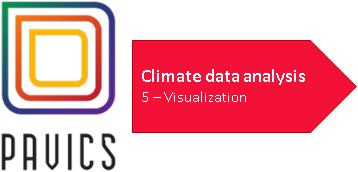
<a id='top'></a>

This tutorial outlines steps for visualizing and summarizing climate data into usable information and visualizations. These types of workflows and representations, often found on climate change information portals such as Ouranos' [climate portraits](https://www.ouranos.ca/climate-portraits/#/) or the canada-wide scale [climatedata.ca](https://climatedata.ca/), include:
* [Maps of climate normals](#maps)
* [Time-series plots](#timeseries)
* [Table summaries](#tables)

Advanced topics:
* [Interactive dashboarding](#advanced)
___
<a id='notes'></a>

*NOTES : To run this series of tutorials in the PAVICS jupyterhub, notebooks should be copied into your 'writable-workspace' directory*  


*Note on ensemble stastics and percentiles : It is critical to always retain all ensemble realizations throughout all data treatment steps when creating a new type of summary output (for example annual spatial-means, or 30 year climate normals) such that the step is the calculation of ensemble percentiles (or mean, min, max) between realizations.  In general one should try to remember that the mean of percentile, (or min, max) values does not equal the percentile (min, max) of the mean conditions*



## Ensemble dataset preparation
We will re-use the concepts of the ensembles tutorial in a slightly more complex workflow to prepare a dataset containing climate indicator output of both RCP 4.5 and RCP 8.5 simulations

*[return to top of page](#top)*

In [1]:
# Sub function definitions
def unstack_yr_season(ds):
    """Translate resampled data to a multi-index year [int] / season [string]"""
    
    ind = pd.MultiIndex.from_arrays([ds.time.dt.year.values + (ds.time.dt.month.values == 12).astype(int),
                                          ds.time.dt.month.values],
                                         names=['year', 'season'])
    dsout = ds.assign(time=ind).unstack('time')
    if len(pd.unique(dsout.season.values)) == 12:
        seas_label = [calendar.month_name[m] for m in range(1,13)]
    else:
        all_labels = {1: 'Annual', 3: 'Spring', 6: 'Summer', 7: 'Annual (jul-jun)', 9: 'Fall', 12: 'Winter'}
        seas_label = [all_labels[m] for m in pd.unique(dsout.season.values)]
    return dsout.assign_coords(season=seas_label)


In [2]:
from xclim import ensembles as xens
import pandas as pd
from clisops.core import subset
import xarray as xr
from pathlib import Path
import numpy as np
from xclim.core import units
import panel as pn
import holoviews as hv
from holoviews import streams
import hvplot
import hvplot.pandas
import hvplot.xarray
from bokeh.models.tools import HoverTool
import warnings
import logging

logging.getLogger().disabled = True
warnings.simplefilter("ignore")

infolder = Path('output')

ds_all =[]
for rcp in ['rcp45','rcp85']:
    ds_vars = []
    for v in ['tx_mean','tx_days_above']:
        ncfiles = [d for d in infolder.glob(f'{v}*{rcp}*.nc')]

        #Create an ensemble dataset from the 11 simulations for the given rcp
        # Add a new rcp dimension and corodinate
        ds_vars.append(xens.create_ensemble(ncfiles).assign_coords(rcp=rcp).expand_dims('rcp'))
    
    # Create a single dataset with both variables
    ds_all.append(xr.merge(ds_vars))

#concatenate the 2 rcp datasets together along the new 'rcp' dim
ds_ens = xr.concat(ds_all, dim='rcp')
ds_ens

<xarray.Dataset>
Dimensions:        (lat: 18, lon: 44, rcp: 2, realization: 11, time: 481)
Coordinates:
  * time           (time) datetime64[ns] 1980-12-01 1981-03-01 ... 2100-12-01
  * lat            (lat) float32 49.29 49.21 49.12 49.04 ... 48.04 47.96 47.87
  * lon            (lon) float32 -67.71 -67.63 -67.55 ... -64.3 -64.21 -64.13
  * realization    (realization) int64 0 1 2 3 4 5 6 7 8 9 10
  * rcp            (rcp) object 'rcp45' 'rcp85'
Data variables:
    tx_mean        (rcp, realization, time, lat, lon) float32 dask.array<chunksize=(1, 1, 481, 18, 44), meta=np.ndarray>
    tx_days_above  (rcp, realization, time, lat, lon) float64 dask.array<chunksize=(1, 1, 481, 18, 44), meta=np.ndarray>

<a id='maps'></a>
___
## Maps of climate normals
In this section we examine steps to create an interactive map of 30 year climatologies. First we calculate 30 year averages on our ensemble dataset
as well as a subsequent delta change calculation with respect to a reference period. We then calculate ensembles percentiles of the 30 year normals. Finally we employ [holoviz](https://holoviz.org/) tools to create an interactive figure to explore the data.

*Notes : 1) Remember the importance of calculating ensemble percentiles as a last step (see [notes](#notes)). 2) Unstacking" the time dimension via the custom sub-function `unstack_yr_season` allows us to calculate 30 year averages for all seasons simultaneously with `xarray` operations such as [rolling](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.rolling.html) or [coarsen](https://xarray.pydata.org/en/v0.12.0/generated/xarray.Dataset.coarsen.html)*

*[return to top of page](#top)*

In [9]:
# 30 year means and delta calculations
ds2d = unstack_yr_season(ds_ens)
window = 30
d30yAvg = ds2d.rolling(year=window).mean().sel(year=slice(ds2d.year[0]+window-1,2100))
horizons = xr.DataArray([f'{yr - 29}-{yr}' for yr in d30yAvg.year.values], dims=dict(year=d30yAvg.year))
d30yAvg = d30yAvg.assign_coords(horizon=horizons)

# Select every horizons in 10 y intervals
d30yAvg = d30yAvg.sel(year=(d30yAvg.year.values%10==0))
for v in d30yAvg.data_vars:
    if units.units2pint(d30yAvg[v]) == 'kelvin':
        d30yAvg[v] = units.convert_units_to(d30yAvg[v], 'degC')


# Calculate deltas
ref = d30yAvg.sel(year=(d30yAvg.horizon=='1981-2010')).squeeze()
for v in d30yAvg.data_vars:
    with xr.set_options(keep_attrs=True):
        d30yAvg[f"{v}_delta"]= d30yAvg[v] - ref[v]
        for a in ['description', 'long_name']:
            d30yAvg[f"{v}_delta"].attrs[a] = f"{d30yAvg[f'{v}_delta'].attrs[a]} : delta vs 1981-2010"
        

# Calculate percentiles on 30y normals
d30yAvg_ens = xens.ensemble_percentiles(d30yAvg, split=False).load()
display(d30yAvg_ens)
map1 = d30yAvg_ens.hvplot.quadmesh(z='tx_mean', cmap='Spectral_r', geo=True,tiles=True)
map1

<xarray.Dataset>
Dimensions:              (lat: 18, lon: 44, percentiles: 3, rcp: 2, season: 4, year: 10)
Coordinates:
  * lat                  (lat) float32 49.29 49.21 49.12 ... 48.04 47.96 47.87
  * lon                  (lon) float32 -67.71 -67.63 -67.55 ... -64.21 -64.13
  * rcp                  (rcp) object 'rcp45' 'rcp85'
  * year                 (year) int64 2010 2020 2030 2040 ... 2080 2090 2100
  * season               (season) <U6 'Spring' 'Summer' 'Fall' 'Winter'
    horizon              (year) <U9 '1981-2010' '1991-2020' ... '2071-2100'
  * percentiles          (percentiles) int64 10 50 90
Data variables:
    tx_mean              (rcp, lat, lon, year, season, percentiles) float64 n...
    tx_days_above        (rcp, lat, lon, year, season, percentiles) float64 n...
    tx_mean_delta        (rcp, lat, lon, year, season, percentiles) float64 n...
    tx_days_above_delta  (rcp, lat, lon, year, season, percentiles) float64 n...
Attributes:
    xclim_history:  [2021-02-23 15:53:14] : Computation of the percentiles on...

:DynamicMap   [percentiles,season,year,rcp]
   :Overlay
      .Tiles.I    :Tiles   [x,y]
      .QuadMesh.I :QuadMesh   [lon,lat]   (tx_mean)

___
<a id='timeseries'></a>
### Regional averaging and time-series graphs
Here we employ tools to create time series graphs for a number of sub-regions of interest. We first calculate the proportion of individual gridcells intersecting each sub-region in order to calculate a weighted average of conditions for each sub-region.  *Remember the importance of calculating ensemble percentiles as a last step (see [notes](#notes))*
  


*[return to top of page](#top)*

In [10]:
from clisops.core import average
import geopandas as gpd
import hvplot.pandas
gdf = gpd.GeoDataFrame.from_file('tutorial_data/gaspesie_mrc.geojson')
gdf = gdf.dissolve(by='MUS_NM_MRC')
gdf['region_name'] = gdf.index

# TODO replace with clisops average.average_shape() once it can do a 'skipna'
# mask of valid (non-nan) data cells
data_mask = ds_ens.tx_mean.isel(rcp=0, realization=0).mean(dim='time').notnull()
# spatial weights of gridcells interesecting each polygon
weight_masks = subset.create_weight_masks(ds_ens, poly=gdf)
def clean_masks(data_mask, masks):
    #remove weight values of grid that are nan in the actual data. Rescale so total == 1 
    return (masks * data_mask) / (masks * data_mask).sum(dim=['lat', 'lon'])

weight_masks = clean_masks(data_mask, weight_masks)

# Calculate weighted average for each region
with xr.set_options(keep_attrs=True):
    reg_ts_sims = (ds_ens * weight_masks).sum(dim=['lat','lon'])
    
    for v in reg_ts_sims.data_vars:
        if units.units2pint(reg_ts_sims[v]) == 'kelvin':
            reg_ts_sims[v] = units.convert_units_to(reg_ts_sims[v], 'degC')
    reg_ts = unstack_yr_season(xens.ensemble_percentiles(reg_ts_sims))
reg_ts.load()
# get only tx_mean variables
vars1 = [v for v in reg_ts if 'tx_mean' in v]
gdf.hvplot(geo=True, color='region_name',tiles=True, legend=False, frame_width=400) + reg_ts[vars1].hvplot.line(x='year', frame_width=400).opts(legend_position='top_left')

:Layout
   .Overlay.I    :Overlay
      .Tiles.I    :Tiles   [x,y]
      .Polygons.I :Polygons   [Longitude,Latitude]   (region_name)
   .DynamicMap.I :DynamicMap   [season,geom,rcp]
      :NdOverlay   [Variable]
         :Curve   [year]   (value)

<a id='tables'></a>
## Summary tables
Here we produce a summary table of regional 30 year means for all variables and horizons.  *Remember the importance of calculating ensemble percentiles as a last step (see [notes](#notes))*


*[return to top of page](#top)*

In [11]:
# Start with 30 year means from mapping step
# Calculate weighted average for each region
with xr.set_options(keep_attrs=True):
    reg30y_sims = (d30yAvg * weight_masks).sum(dim=['lat','lon'])
    
    for v in reg30y_sims.data_vars:
        if units.units2pint(reg30y_sims[v]) == 'kelvin':
            reg30y_sims[v] = units.convert_units_to(reg30_sims[v], 'degC')
    reg30y_ens = xens.ensemble_percentiles(reg30y_sims)
    df = reg30y_ens.swap_dims(dict(year='horizon')).rename({'geom':'region'}).to_dataframe()
   

In [13]:
df.hvplot.table(title='Summary table',fit_columns=False, sortable=True, selectable=True, width=2000)

:Table   [horizon,rcp,region,season,tx_mean_p10,tx_mean_p50,tx_mean_p90,year,region_name,tx_days_above_p10,tx_days_above_p50,tx_days_above_p90,tx_mean_delta_p10,tx_mean_delta_p50,tx_mean_delta_p90,tx_days_above_delta_p10,tx_days_above_delta_p50,tx_days_above_delta_p90]

<a id='advanced'></a>
___
## Advanced interactive plots and dashboarding
While simple interactive plots can rapidly be achieved using the xarray or pandas [`hvplot`](https://hvplot.holoviz.org/user_guide/Gridded_Data.html) extensions more powerful custom controls can be accomplished by leveraging [panel](https://panel.holoviz.org/) for the creation of custom widgets and controls allowing for interactive maps and figures with standardized color limits and options such as variable selection, display of delta change values, and opacity.

*[return to top of page](#top)*

### Dashboarding - advanced controls & mapping

In [25]:
## widgets setup

# variable menu
vars = pn.widgets.Select(options=[v for v in list(d30yAvg_ens.data_vars.keys()) if '_delta' not in v], width=125)
vars1 = pn.Column(pn.pane.Markdown('**Select variable**'),vars)

# delta checkbox
delta = pn.widgets.Checkbox(value=False)
delta1 = pn.Column(pn.pane.Markdown('**display deltas**'),delta)

# seasons menu
seasons = pn.widgets.Select(options=list(d30yAvg_ens.season.values), value='Summer', width=125)
seasons1 = pn.Column(pn.pane.Markdown('**season**'),seasons)

# percentiles menu
perc = pn.widgets.RadioButtonGroup(options=list(d30yAvg_ens.percentiles.values), value=50, width=125)
perc1 = pn.Column(pn.pane.Markdown('**ensemble percentile**'),perc)

# horizons menu
hors = pn.widgets.DiscreteSlider(options=list(d30yAvg_ens.horizon.values), value='2041-2070', width=200)
hors1 = pn.Column(pn.pane.Markdown('**horizon**'),hors)

# rcps menu
rcps = pn.widgets.RadioButtonGroup(options=list(d30yAvg_ens.rcp.values), value='rcp85', width=125)
rcps1 = pn.Column(pn.pane.Markdown('**emissions scenario**'),rcps)

# regions menu
regions = pn.widgets.Select(options=list(reg_ts.geom.values))
regions1 = pn.Column(pn.pane.Markdown('**region**'),regions)

# transparency control
trs = pn.widgets.FloatInput(value=0.8, start=0.0, end=1.0, step=0.2, width = 60)
trs1 = pn.Column(pn.pane.Markdown('opacity'),trs)


## Dynamically change map using the pn.depends decorator
@pn.depends(vars.param.value, seasons.param.value, perc.param.value, 
            hors.param.value, rcps.param.value, trs.param.value, delta.param.value)
def plot_map(v=vars.param.value, s=seasons.param.value, p=perc.param.value, h=hors.param.value, 
             r=rcps.param.value, alpha=trs.param.value, delta_flag=delta.param.value):   
    out = d30yAvg_ens.swap_dims(dict(year='horizon'))
    if delta_flag:
        v = f"{v}_delta"
        tool_lab = f"delta vs {ref.horizon.values} ({out[v].attrs['units']})"
    else:
        tool_lab = f"{out[v].attrs['long_name']}  ({out[v].attrs['units']})"
    clim = (out[v].sel(season=s).min().values, out[v].sel(season=s).max().values)
    out = out.sel(season=s, percentiles=p, horizon=h, rcp=r)
    hover = HoverTool(tooltips=[(tool_lab, f"@{v}")])
    title = pn.pane.Markdown(f"### {s} {out[v].attrs['long_name'].lower()} ({out[v].attrs['units'].lower()})<br/> {h} : {r} ({p}th percentile)".replace('  ',' '))
    return pn.Column(title,pn.Row(out.hvplot.quadmesh(z=v,alpha=alpha,xlabel='lon',
                                                      ylabel='lat', cmap='Spectral_r', 
                                                      clim=clim, geo=True, tiles='CartoLight', 
                                                      tools=[hover],frame_width=650),trs1))

map1 = pn.Column(plot_map, pn.Row(vars1, seasons1, rcps1, perc1, hors1, delta1))
# map1  # Uncomment to visualization map-only

### Dashboarding - time-series and summary table
* add regional time-series plot 
* add table summary of all seasons for selected region & horizon
* combine the three elements into simple dashboard

In [26]:
rolling = pn.widgets.FloatInput(value=30, step=10, start=10, end=30, width=50)
rolling1 = pn.Column(pn.pane.Markdown('Smoothing'),rolling)

## Time-series plot
@pn.depends(vars.param.value, regions.param.value, seasons.param.value, rolling.param.value)
def plot_region_ts(v=vars.param.value, reg=regions.param.value, s=seasons.param.value, wind=rolling.param.value): 
    colors = dict(rcp45="#0000FF",rcp85="#FF0000")
    plt1 = None
    wind = max(wind,1)
    for r in reg_ts.rcp.values:
        
        if plt1 is None:
            plt1 = reg_ts.rolling(year=wind, center=True, min_periods=1).mean(dim='year').sel(geom=reg, season=s, rcp=r).hvplot.area(title=f"{reg} {s}",
                width=800, height=300, x='year', y= f"{v}_p10", y2= f"{v}_p90", 
                color=colors[r], alpha=0.3, line_alpha=.1, 
                label=f"RCP {r[-2:].replace('5','.5')}")     
            plt1 = plt1 * reg_ts.rolling(year=wind, center=True, min_periods=1).mean(dim='year').sel(geom=reg, season=s, rcp=r).hvplot.line(
                x='year', y= f"{v}_p50", color=colors[r], alpha=0.7, label=f"RCP {r[-2:].replace('5','.5')}") 
            
                
        else: 
            plt1 = plt1 * reg_ts.rolling(year=wind, center=True, min_periods=1).mean(dim='year').sel(geom=reg, season=s, rcp=r).hvplot.area(
                x='year', y=v + '_p10', y2= v + '_p90',color=colors[r], alpha=0.3, line_alpha=.1, label=f"RCP {r[-2:].replace('5','.5')}")                                                                                              
            plt1 = plt1 * reg_ts.rolling(year=wind, center=True, min_periods=1).mean(dim='year').sel(geom=reg, season=s, rcp=r).hvplot.line(
                x='year', y= f"{v}_p50", color=colors[r], alpha=0.7, label=f"RCP {r[-2:].replace('5','.5')}") 
        for vv in ['_p10','_p90']:
                plt1 = plt1 * reg_ts.rolling(year=wind, center=True, min_periods=1).mean(dim='year').sel(geom=reg, season=s, rcp=r).hvplot.line(
                x='year', y= f"{v}{vv}", color=colors[r], line_width=0.1, alpha=0.3, label=f"RCP {r[-2:].replace('5','.5')}")
    title = pn.pane.Markdown(f"### {s} {reg_ts[f'{v}_p50'].attrs['long_name'].lower()} ({reg_ts[f'{v}_p50'].attrs['units'].lower()})<br/><br/>")
  
    return pn.Column(pn.Row(plt1.opts(legend_position='top_left'), rolling1))

## Table summary
@pn.depends(vars.param.value, regions.param.value, hors.param.value, delta.param.value)
def create_table(v = vars.param.value, r=regions.param.value, h=hors.param.value, delta_flag=delta.param.value):
    title1 = f"Summary : {r} {h}"
    var_cols = var_cols =  [vv for vv in df.columns if v in vv]
    if delta_flag:
        var_cols = [vv for vv in var_cols if 'delta' in vv]
        title1 = f"{title1} (delta vs 1981-2010)"
    else:
        var_cols = [vv for vv in var_cols if 'delta' not in vv]
    out = df[var_cols].iloc[(df.index.get_level_values('horizon') == h)&(df.index.get_level_values('region') == r)]
    return(out.sort_values(['season']).round(decimals=1).hvplot.table(title=title1, width=800, dynamic=True))

pn.Column(pn.pane.Markdown('# A simple PAVICS dashboard'), map1, regions1, plot_region_ts, create_table)

Column
    [0] Markdown(str)
    [1] Column
        [0] ParamFunction(function)
        [1] Row
            [0] Column
                [0] Markdown(str)
                [1] Select(options=['tx_mean', 'tx_days_above...], value='tx_mean', width=125)
            [1] Column
                [0] Markdown(str)
                [1] Select(options=['Spring', 'Summer', ...], value='Summer', width=125)
            [2] Column
                [0] Markdown(str)
                [1] RadioButtonGroup(options=['rcp45', 'rcp85'], value='rcp85', width=125)
            [3] Column
                [0] Markdown(str)
                [1] RadioButtonGroup(options=[10, 50, 90], value=50, width=125)
            [4] Column
                [0] Markdown(str)
                [1] DiscreteSlider(options=['1981-2010', ...], value='2041-2070', value_throttled='2041-2070', width=200)
            [5] Column
                [0] Markdown(str)
                [1] Checkbox()
    [2] Column
        [0] Markdown(str)
        [1] Select(options=['Avignon', 'Bonaventure',...], value='Avignon')
    [3] ParamFunction(function)
    [4] ParamFunction(function)